In [61]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import collections
import utils
import make_query
import queries
import control
import visualizations
import mining


In [5]:
def make_Graph(df, v1, v2, edge):
    
    if v1 == v2:
        print("(ERROR)\t Source and Destination vertices cannot be same column.")
        return None
    G = nx.from_pandas_edgelist(df, source=v1, target=v2, edge_attr=edge, create_using=nx.DiGraph())
    print(G)
    return G



def random_Subgraph(G, df, v1, n):
    """Generate a random subgraph

    Args:
        G (nx.Graph): Full Graph Object
        df (pd.DataFrame): pandas dataframe of transactions
        v1 (string): origin node
        n (int): number of nodes to put in new graph

    Returns:
        nx.Graph: subgraph of larger graph
    """
    spl = df.sample(n)[v1]
    
    subG = G.subgraph(spl)
    print(subG)
    return subG


In [3]:
comp_txs = pd.read_csv("compound_txs.csv")
comp_txs.shape

(40331, 6)

In [4]:
cG = make_Graph(comp_txs, "from", "to", "amount")


DiGraph with 12949 nodes and 18354 edges
DiGraph with 12949 nodes and 18354 edges


In [47]:
cG_subgraph = random_Subgraph(cG, comp_txs, "from", 750)


DiGraph with 319 nodes and 850 edges


In [39]:
def draw_transaction_graph_heatmap(G, addr, labels=True):
    """Used Matplotlib to draw a heatmap graph showing
    the number of transactions between addresses (nodes)

    Args:
        G (networkx.classes.digraph.DiGraph): Directed Graph of Transactions
        addr (string): Original Address
    """
    pos = nx.spring_layout(G)

    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    cmap = plt.cm.YlOrRd
    
    plt.figure(figsize=(12, 10), dpi=100)
    
    
    nodes = nx.draw_networkx_nodes(
        G, pos, node_size=20, node_color="indigo")
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=5,
        arrowstyle="->",
        arrowsize=20,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=2,
    )

    if labels:
        nx.draw_networkx_labels(
            G,
            pos,
            font_size=8,
            horizontalalignment='right',
            verticalalignment='top',
            clip_on=False
        )

    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])

    plt.title("Txs:  {0}".format(addr))
    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)
    cbar = plt.colorbar(pc)
    cbar.set_label('# of transactions')
    
    ax = plt.gca()
    ax.set_axis_off()
    plt.show()


/var/folders/cs/cv1ys6cn52ld9z99yrbpcwbc0000gn/T/ipykernel_53004/709106333.py:49: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(pc)


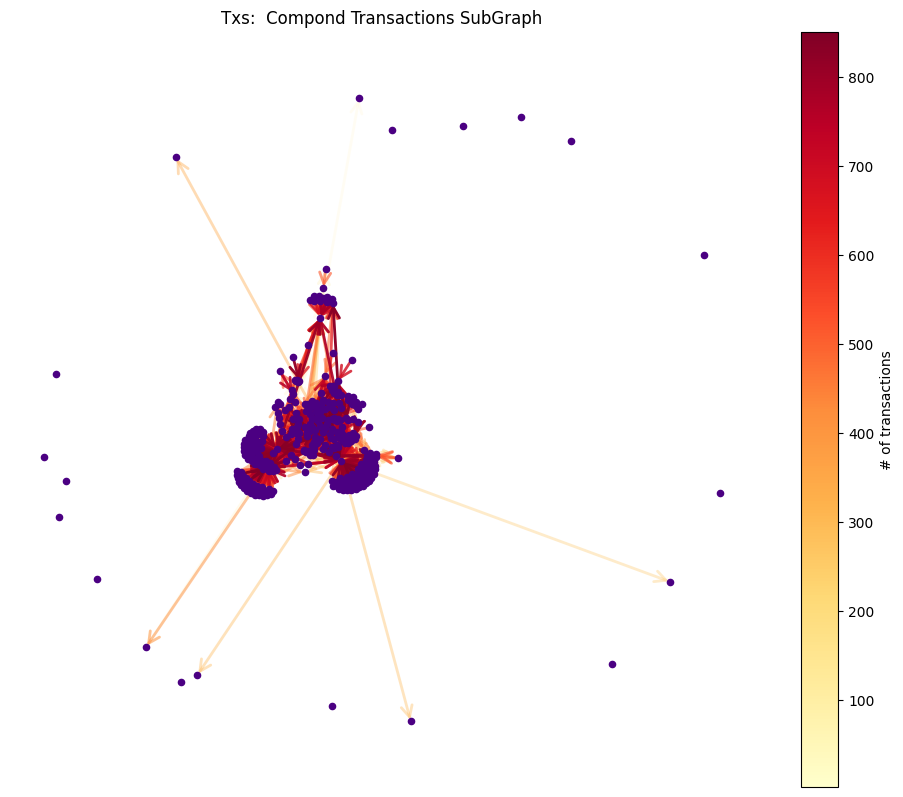

In [48]:
draw_transaction_graph_heatmap(cG_subgraph, "Compond Transactions SubGraph", False)


In the Graph you can see some grouping of the nodes into distinct groups. The grouping of the nodes uses the Fruchterman-Reingold force-directed algorithm, so the nodes inherently want to be far apart but the edges will attach nodes based on the value of the edge (amount). In most cases these represent pools where the connect with other pools to trade but most of the transactions are within the the Pool, dealing out payments, rewards etc. 
  
Note: This is made with a subgraph, with the full graph there are too many nodes, too much crowding to see the actual transaction hubs. 

In [64]:
# Graph Mining Analytic Metrics

asp = mining.avg_shortest_path(cG)
scc, wcc = mining.strong_weak_connected_components(cG)
pl_coeff = mining.power_law_coeff(cG)
mining.hub_ratio_estimation(cG)
deg, clo = mining.centrality_detection(cG)



100%|██████████| 12949/12949 [00:51<00:00, 249.77it/s]


Average shortest path length: 3.50
Strongly Connected Component Sizes:
	Found 10584 SCCs with size 1.
	Found 10 SCCs with size 2.
	Found 1 SCCs with size 3.
	Found 1 SCCs with size 2332.
	Found 2 SCCs with size 5.
Weakly Connected Component Sizes:
	Found 1 WCCs with size 12522.
	Found 176 WCCs with size 2.
	Found 18 WCCs with size 3.
	Found 1 WCCs with size 9.
	Found 3 WCCs with size 4.
Power-law coefficient: 4.657751419378948
81 hubs identified from 12949 nodes:
Hub Ratio Degree Threshold: 9.47
Ratio of hubs: 0.00625531
Most Central Addresses (Degree):  [('0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5', 0.5617083719493358), ('0x39aa39c021dfbae8fac545936693ac917d5e7563', 0.16427247451343838), ('0x5d3a536e4d6dbd6114cc1ead35777bab948e3643', 0.14102564102564102), ('0xf650c3d88d12db855b8bf7d11be6c55a4e07dcc9', 0.09244670991658943), ('0xccf4429db6322d5c611ee964527d42e5d685dd6a', 0.06356194006796416)]

Most Central Addresses (Closeness):  [('0x220bda5c8994804ac96ebe4df184d25e5c2196d4', 0.231735

All of the most central addresses are actually contract address, which is what we expected. The contracts work by making automated trades and automatically managing pools. Some of these work to move tokens cross-chain making it most central because its a common way to people to move money across blockchains